In [66]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

In [67]:


train_dir = os.path.join('./train')
validation_dir = os.path.join('./val')
test_dir = os.path.join('./test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 10612 files belonging to 3 classes.


In [68]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1178 files belonging to 3 classes.


In [69]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 300 files belonging to 3 classes.


Show the first nine images and labels from the training set:

In [70]:
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Print the true labels
print('True Labels:\n', true_labels)

True Labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


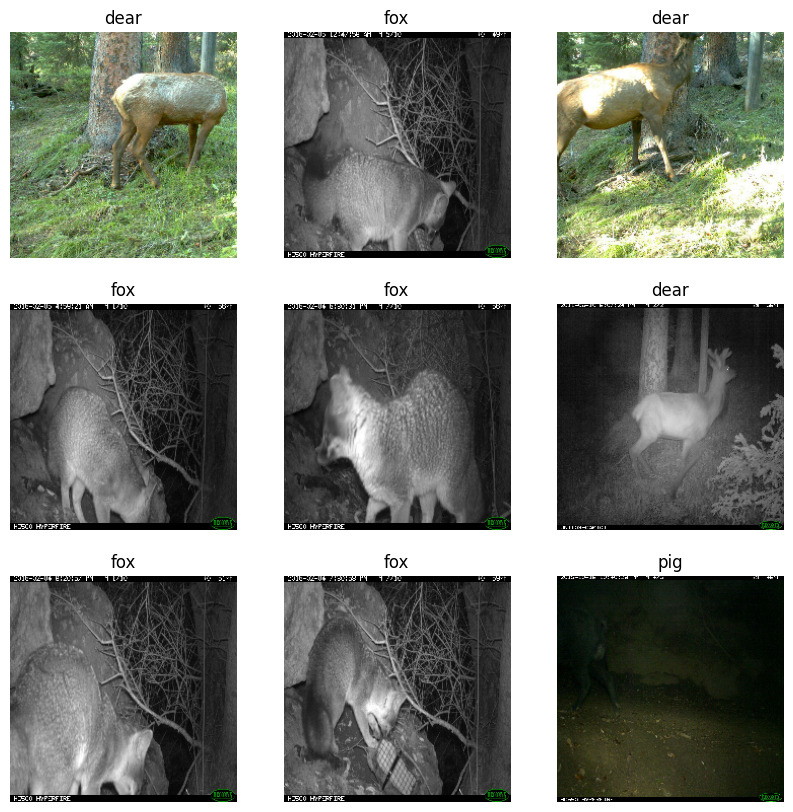

In [71]:
class_names = ['dear', 'fox', 'pig']

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [72]:
val_batches = tf.data.experimental.cardinality(validation_dataset)



In [73]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 37
Number of test batches: 10


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. 

In [74]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [75]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

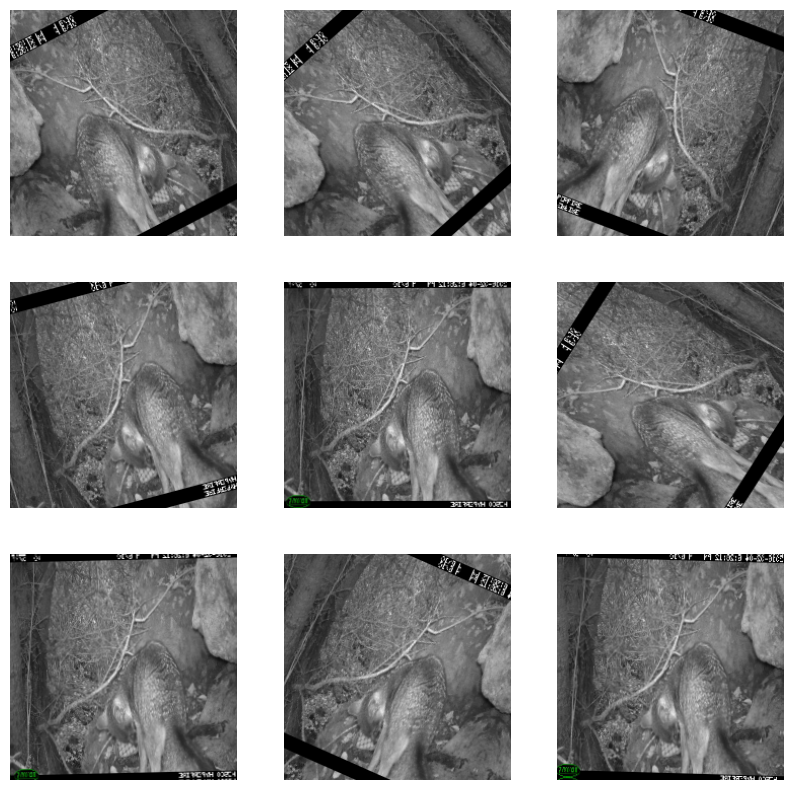

In [76]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [77]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [78]:
rescale = tf.keras.layers.Rescaling(1./255, offset=-1)

## Create the base model from the pre-trained convnets

In [79]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [80]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## Feature extraction
In this step, will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally,add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [81]:
base_model.trainable = False

In [82]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [83]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [84]:
from tensorflow.keras import regularizers
prediction_layer = tf.keras.layers.Dense(3,activation='softmax',name='prediction',kernel_regularizer=regularizers.l2(0.01))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [85]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [86]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

In [87]:
len(model.trainable_variables)

2

In [88]:

import tensorflow as tf
import os

# Set the number of parallel execution units
NUM_PARALLEL_EXEC_UNITS = 8

# Configuring TensorFlow Session
config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


# MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1"

2024-01-20 19:16:15.436309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:16:15.436454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:16:15.436490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:16:15.436773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:16:15.436790: I tensorflow/core/common_runtime/gpu/gpu

In [89]:
model_name = "MobileNetV2"

models_dir = os.path.join('./models')
model_dir = os.path.join(models_dir, model_name)
model_save_dir = os.path.join(model_dir, model_name)
model_save_path = os.path.join(model_save_dir, model_name + "_base.h5")


if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [90]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger
# Save the model with best weights
top_layers_file_path = os.path.join(model_save_dir, model_name + "_top_layers.h5")

# Save the model after every epoch.
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# Save the TensorBoard logs.
tb = TensorBoard(log_dir='./logs', write_graph=True, update_freq='batch')
# Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor="loss", mode="min", patience=5)
# Save the CSV logger
csv_logger = CSVLogger('./logs/mobilenetv2-old-log.csv', append=True)

In [91]:
# Check if GPU is available
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')
print("GPU Devices:", devices)

GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [92]:


from datetime import datetime


def accuracy_loss_plot(history, model_config):
    epochs = history.epoch
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    run_epochs = len(epochs)

    f = 1
    save_epochs = [epochs[i] for i in range(0, run_epochs, f)]
    save_tr_acc = [tr_acc[i] for i in range(0, run_epochs, f)]
    save_tr_loss = [tr_loss[i] for i in range(0, run_epochs, f)]
    save_val_acc = [val_acc[i] for i in range(0, run_epochs, f)]
    save_val_loss = [val_loss[i] for i in range(0, run_epochs, f)]

    # Create a figure and axis
    fig, ax1 = plt.subplots()

    fig.set_figheight(12)
    fig.set_figwidth(24)

    # Plot accuracy lines
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.plot(save_epochs, save_tr_acc, color='#800000', marker='o', label='Training Accuracy')
    ax1.plot(save_epochs, save_val_acc, color='#000075', marker='x', label='Validation Accuracy')
    # ax1.set_xticklabels(save_epochs, rotation=90)

    # Create a second y-axis for loss lines
    ax2 = ax1.twinx()  # Share the same x-axis
    ax2.set_ylabel('Loss', color='black')
    ax2.plot(save_epochs, save_tr_loss, color='#3cb44b', marker='s', label='Training Loss')
    ax2.plot(save_epochs, save_val_loss, color='#f58231', marker='^', label='Validation Loss')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    # Set a title
    plt.title('Accuracy and Loss Over Epochs')

    accuracy_matrices_path = os.path.join(os.getcwd(), './metrics/accuracy_matrices')

    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-{model_config}-training_metrics_plot-{format(curr_datetime)}.png'

    if not os.path.exists(accuracy_matrices_path):
        os.makedirs(accuracy_matrices_path)

    # Save the plot to the specified folder
    destination = os.path.join(accuracy_matrices_path, filename)
    plt.savefig(destination, bbox_inches='tight')

### Compile the model

In [93]:
base_learning_rate = 0.0001

model. compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')


### Train the model


In [94]:
initial_epochs = 20
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


332/332 [==============================] - 70s 185ms/step - loss: 0.7169 - accuracy: 0.7236 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3661 - val_accuracy: 0.9117 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/20
332/332 [==============================] - 58s 170ms/step - loss: 0.3482 - accuracy: 0.8978 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.9491 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/20
332/332 [==============================] - 73s 217ms/step - loss: 0.2583 - accuracy: 0.9350 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2018 - val_accuracy: 0.9660 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/20
332/332 [==============================] - 75s 222ms/step - loss: 0.2179 - accuracy: 0.9479 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1757 - val_accuracy: 0.9737 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/20
332/332 [==============================] - 57s 168ms/step - loss: 0.1902 - accuracy: 0.9575 - top_k_categori

2024-01-20 19:26:04.438700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:53: Filling up shuffle buffer (this may take a while): 113 of 256
2024-01-20 19:26:05.253533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


332/332 [==============================] - 88s 260ms/step - loss: 0.1426 - accuracy: 0.9747 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1252 - val_accuracy: 0.9839 - val_top_k_categorical_accuracy: 1.0000
Epoch 10/20
332/332 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9753 - top_k_categorical_accuracy: 1.0000

2024-01-20 19:27:28.929174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:53: Filling up shuffle buffer (this may take a while): 232 of 256
2024-01-20 19:27:29.064496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


332/332 [==============================] - 80s 238ms/step - loss: 0.1393 - accuracy: 0.9753 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1211 - val_accuracy: 0.9839 - val_top_k_categorical_accuracy: 1.0000
Epoch 11/20
332/332 [==============================] - 64s 188ms/step - loss: 0.1287 - accuracy: 0.9788 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1166 - val_accuracy: 0.9839 - val_top_k_categorical_accuracy: 1.0000
Epoch 12/20
332/332 [==============================] - 61s 179ms/step - loss: 0.1247 - accuracy: 0.9789 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 0.9830 - val_top_k_categorical_accuracy: 1.0000
Epoch 13/20
332/332 [==============================] - 60s 176ms/step - loss: 0.1189 - accuracy: 0.9796 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1097 - val_accuracy: 0.9830 - val_top_k_categorical_accuracy: 1.0000
Epoch 14/20
332/332 [==============================] - 61s 181ms/step - loss: 0.1147 - accuracy: 0.9800 - top_k_cate

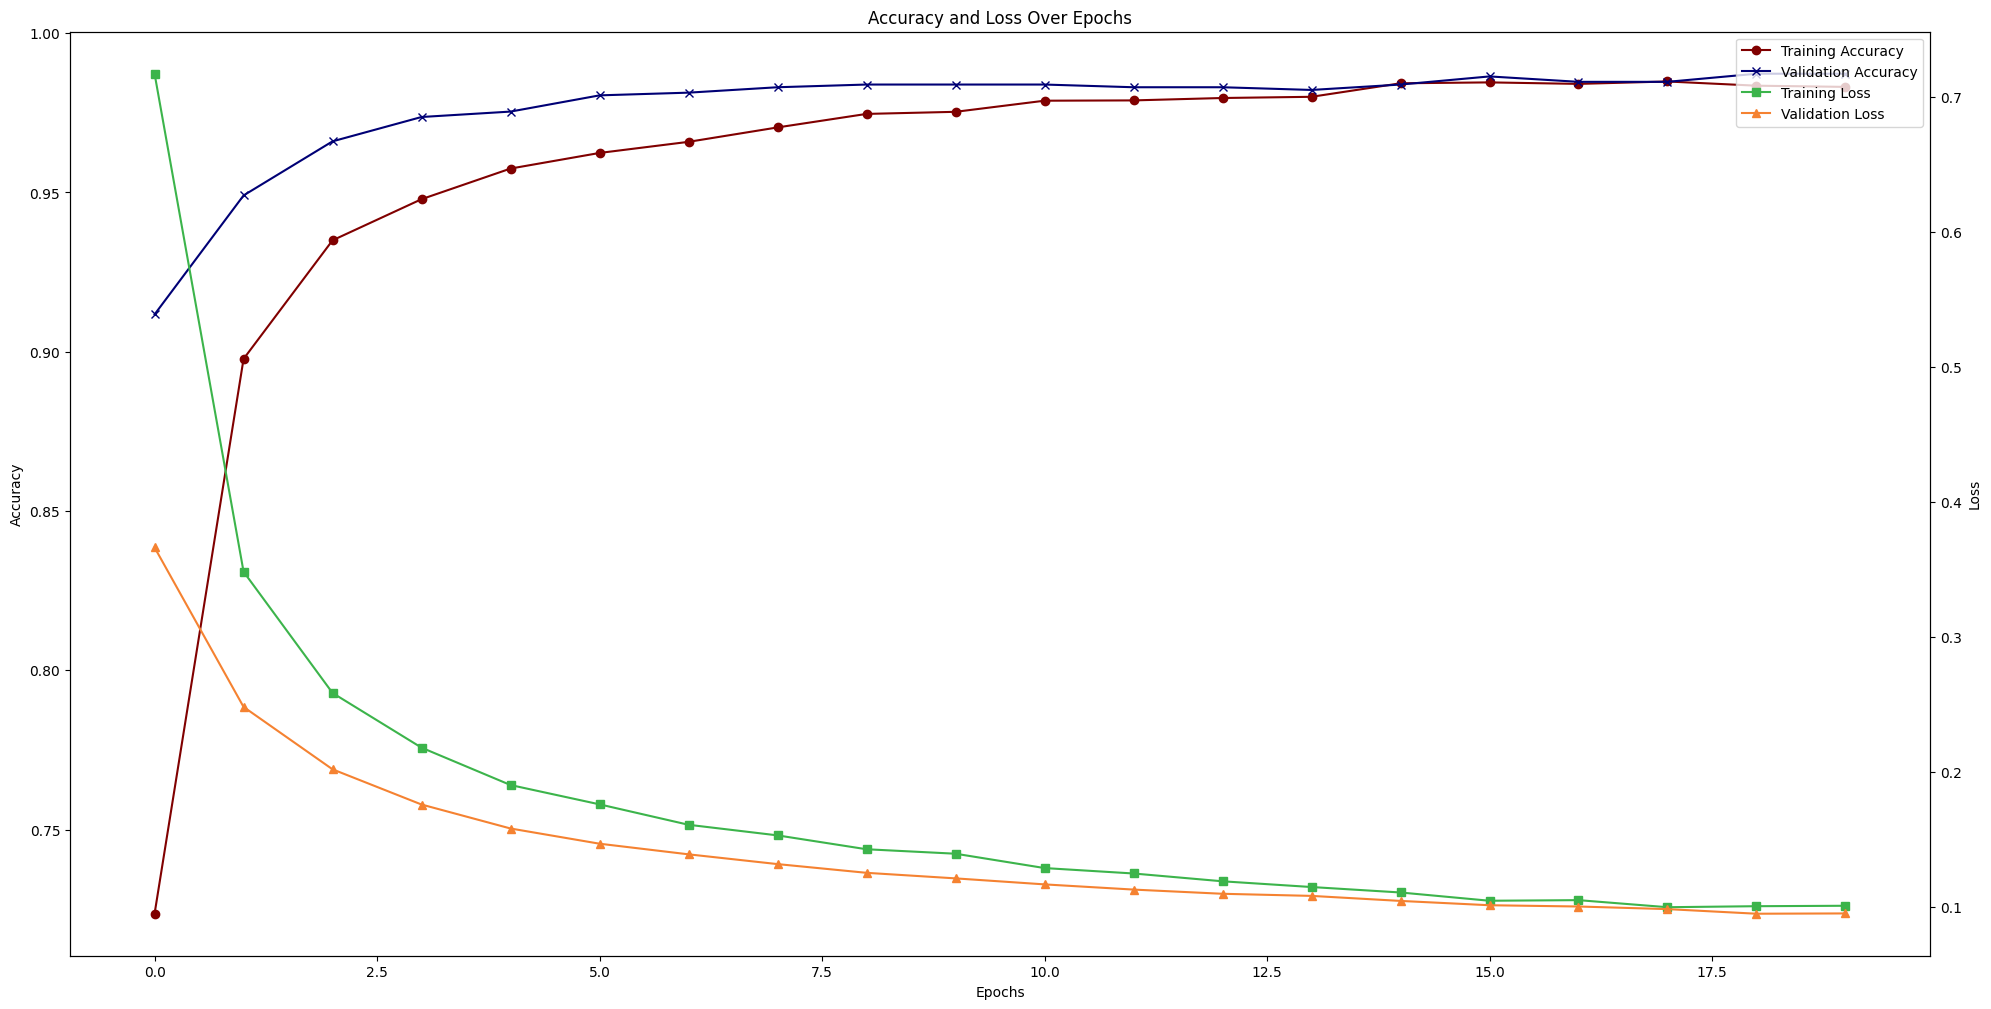

In [95]:
accuracy_loss_plot(history, 'without_tuning')

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)


[0.7236147522926331, 0.8977572321891785, 0.934979259967804, 0.9478892087936401, 0.9575009346008301, 0.9624010324478149, 0.9658876657485962, 0.9704108834266663, 0.9746513366699219, 0.9753109812736511, 0.9787976145744324, 0.9788918495178223, 0.9796456694602966, 0.9800226092338562, 0.9842631220817566, 0.9845458269119263, 0.9840746521949768, 0.9848284721374512, 0.9835092425346375, 0.9831323027610779]
[0.9117147922515869, 0.9490662217140198, 0.9660441279411316, 0.9736841917037964, 0.9753820300102234, 0.9804753661155701, 0.9813242554664612, 0.9830220937728882, 0.9838709831237793, 0.9838709831237793, 0.9838709831237793, 0.9830220937728882, 0.9830220937728882, 0.9821732044219971, 0.9838709831237793, 0.9864176511764526, 0.9847198724746704, 0.9847198724746704, 0.9872665405273438, 0.9872665405273438]


In [97]:
#evaluating the model
accuracy0 = model.evaluate(validation_dataset)

37/37 [==============================] - 6s 129ms/step - loss: 0.0951 - accuracy: 0.9873 - top_k_categorical_accuracy: 1.0000


In [98]:

print("initial accuracy: {:.2f}".format(accuracy0[1]))

initial accuracy: 0.99


### Learning curves

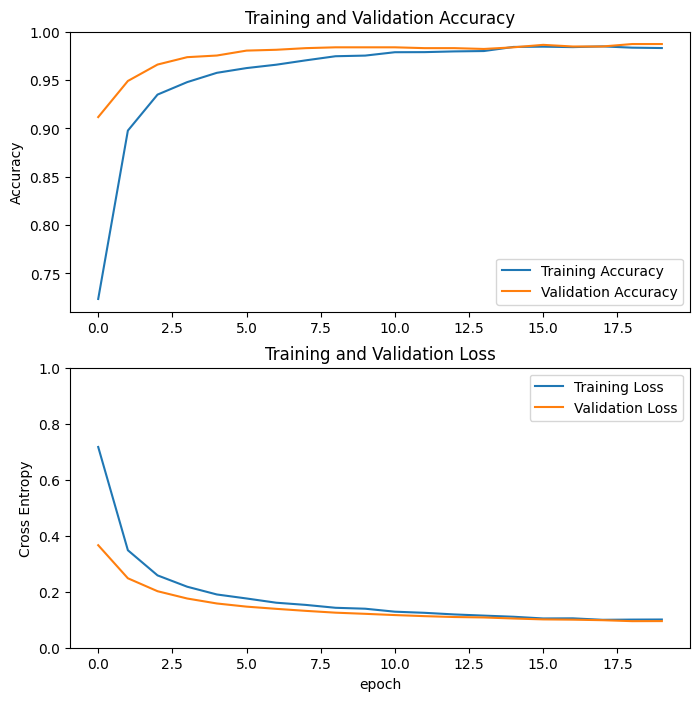

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [100]:
base_model.trainable = True

In [101]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

In [102]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])


In [103]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

In [104]:
len(model.trainable_variables)

56

### Continue training the model

In [105]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


332/332 [==============================] - 75s 140ms/step - loss: 0.0793 - accuracy: 0.9874 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.9847 - val_top_k_categorical_accuracy: 1.0000
Epoch 21/40
332/332 [==============================] - 53s 157ms/step - loss: 0.0557 - accuracy: 0.9947 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 0.9924 - val_top_k_categorical_accuracy: 1.0000
Epoch 22/40
332/332 [==============================] - 60s 178ms/step - loss: 0.0512 - accuracy: 0.9965 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9915 - val_top_k_categorical_accuracy: 1.0000
Epoch 23/40
332/332 [==============================] - 66s 196ms/step - loss: 0.0473 - accuracy: 0.9969 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0464 - val_accuracy: 0.9966 - val_top_k_categorical_accuracy: 1.0000
Epoch 24/40
332/332 [==============================] - 65s 191ms/step - loss: 0.0423 - accuracy: 0.9982 - top_k_cate

2024-01-20 19:44:54.284323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:46: Filling up shuffle buffer (this may take a while): 52 of 256
2024-01-20 19:44:55.778082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


332/332 [==============================] - 96s 251ms/step - loss: 0.0384 - accuracy: 0.9983 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9975 - val_top_k_categorical_accuracy: 1.0000
Epoch 27/40
332/332 [==============================] - 63s 187ms/step - loss: 0.0365 - accuracy: 0.9986 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9975 - val_top_k_categorical_accuracy: 1.0000
Epoch 28/40
332/332 [==============================] - 62s 183ms/step - loss: 0.0334 - accuracy: 0.9991 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9975 - val_top_k_categorical_accuracy: 1.0000
Epoch 29/40
332/332 [==============================] - 70s 208ms/step - loss: 0.0317 - accuracy: 0.9995 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 0.9975 - val_top_k_categorical_accuracy: 1.0000
Epoch 30/40
332/332 [==============================] - 53s 156ms/step - loss: 0.0305 - accuracy: 0.9992 - top_k_cate

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


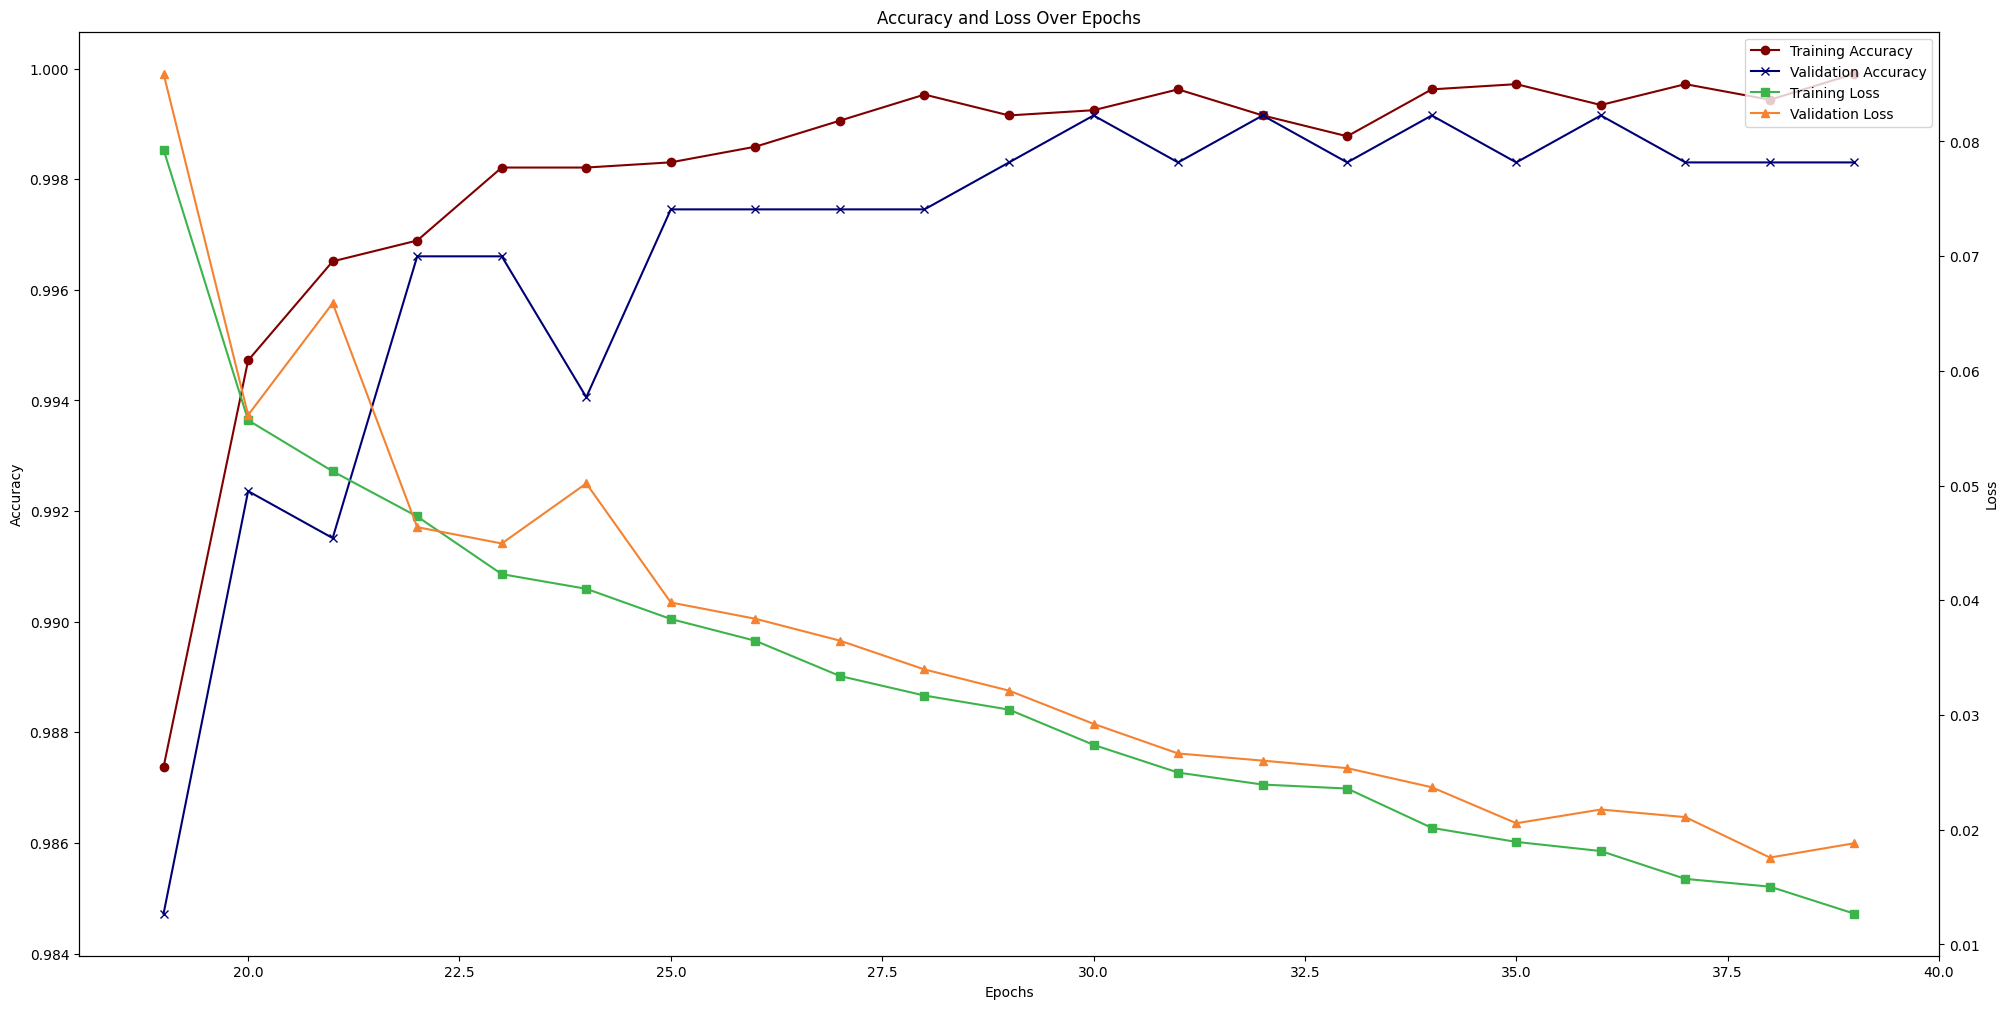

In [106]:
accuracy_loss_plot(history_fine, 'with_tuning')

In [107]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

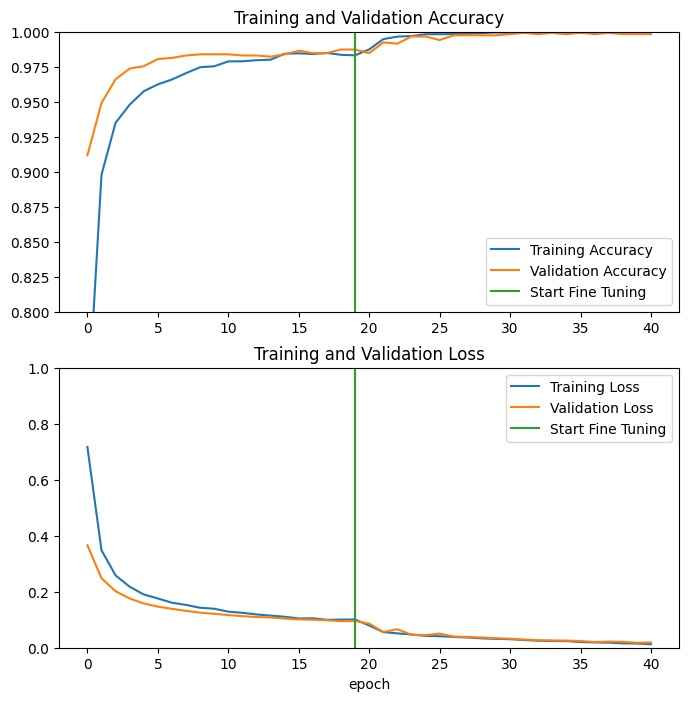

In [108]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [109]:
accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy[1])

10/10 [==============================] - 5s 403ms/step - loss: 0.7297 - accuracy: 0.7400 - top_k_categorical_accuracy: 1.0000
Test accuracy : 0.7400000095367432


In [110]:
# Get the predictions for the test data
predictions = model.predict(test_dataset)

10/10 [==============================] - 5s 120ms/step


Predicted Classes:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 2 0 0 0 2 2 0 0 0 1 0 1 0 0 1 1 0 0 0 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 1 1 1 2 1 2 1 1 2
 1 2 2 2 2 2 2 1 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
True Classes:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

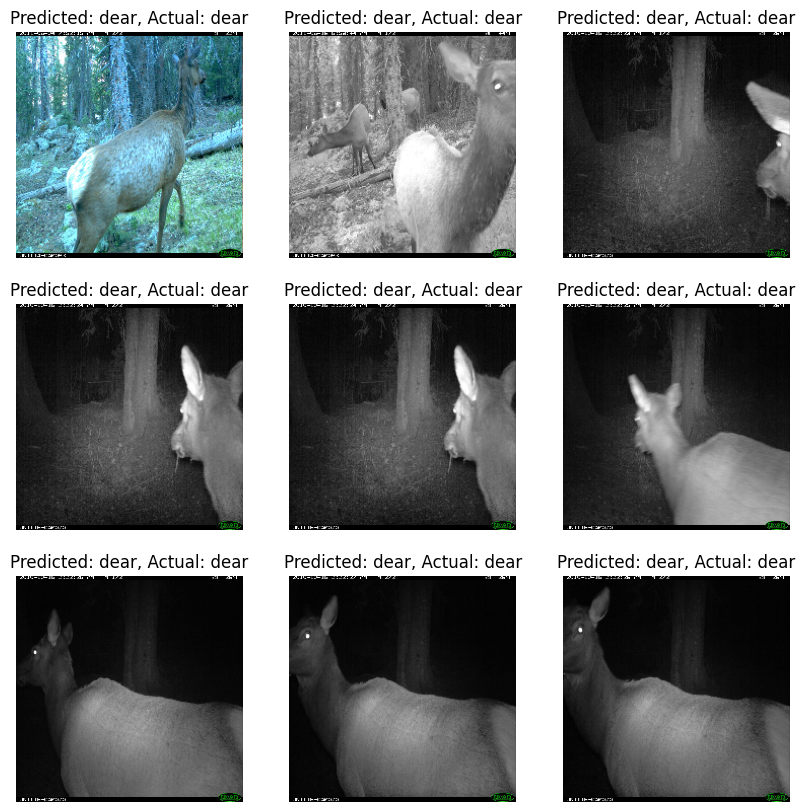

In [111]:

# Apply argmax to get the predicted class
predicted_classes = tf.argmax(predictions, axis=1)


print('Predicted Classes:\n', predicted_classes.numpy())
print('True Classes:\n', np.array(true_labels))

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Predicted: {class_names[predicted_classes[i]]}, Actual: {class_names[labels[i]]}')
    plt.axis("off")


In [112]:

from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


acc = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='macro')
recall = recall_score(true_labels, predicted_classes, average='macro')
f1 = f1_score(true_labels, predicted_classes, average='macro')

metrics_path = os.path.join(os.getcwd(), './metrics/metric_values')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-metrics-{format(curr_datetime)}.txt'

if not os.path.exists(metrics_path):
    os.makedirs(metrics_path)

file_path = os.path.join(metrics_path, filename)
with open(file_path, 'w') as file:
    file.write(f'Accuracy: {acc:.3f}\n')
    file.write(f'Precision: {precision:.3f}\n')
    file.write(f'Recall: {recall:.3f}\n')
    file.write(f'F1 Score: {f1:.3f}\n')
  
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

Accuracy: 0.740
Precision: 0.827
Recall: 0.740
F1 Score: 0.700


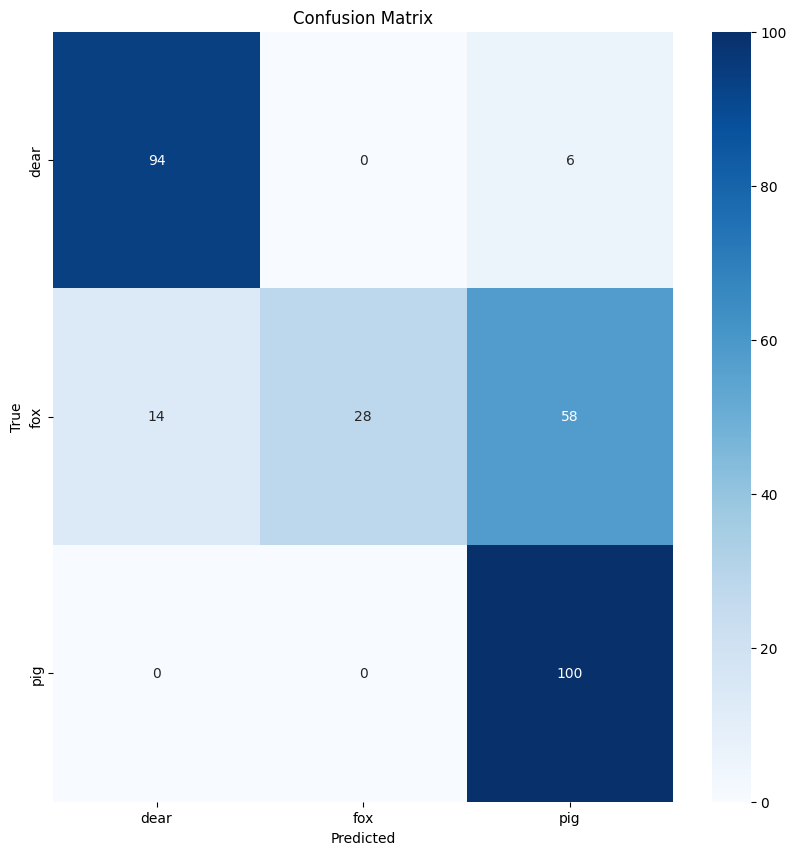

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_res = confusion_matrix(true_labels, predicted_classes)

class_labels = ['dear', 'fox','pig']

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_res, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

confusion_matrix_path = os.path.join(os.getcwd(), './metrics_mobilnet/confusion_matrices')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{"mobilnetv2-old"}-confusion_matrix-{format(curr_datetime)}.png'

if not os.path.exists(confusion_matrix_path):
    os.makedirs(confusion_matrix_path)

# Save the plot to the specified folder
save_path = os.path.join(confusion_matrix_path, filename)
plt.savefig(save_path, bbox_inches='tight')

In [114]:
from datetime import datetime
from itertools import cycle
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve

model_name = 'MobileNetV2'
num_labels=3
class_labels = ['dear', 'fox', 'pig']
def get_ROC_AUC(y_pred, y_target):
    # Binarize the labels
    n_classes = num_labels
    true_labels_bin = label_binarize(y_target, classes=range(n_classes))
    predicted_labels_bin = label_binarize(y_pred, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        print()
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def save_ROC_AUC(fpr, tpr, roc_auc):
    n_classes = num_labels

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 12))

    hex_colors = [
        "#FF0000",  # Red
        "#00FF00",  # Green
        "#0000FF",  # Blue
        "#FFFF00",  # Yellow
        "#FF00FF",  # Magenta
        "#00FFFF",  # Cyan
        "#FFA500",  # Orange
        "#FF4500",  # OrangeRed
        "#FFD700",  # Gold
        "#8A2BE2",  # BlueViolet
        "#7FFF00",  # Chartreuse
        "#DC143C",  # Crimson
        "#48D1CC",  # MediumTurquoise
        "#2E8B57",  # SeaGreen
        "#800080",  # Purple
        "#ADFF2F",  # GreenYellow
        "#FF1493",  # DeepPink
        "#9370DB",  # MediumPurple
        "#8B4513",  # SaddleBrown
        "#20B2AA",  # LightSeaGreen
        "#8B008B",  # DarkMagenta
        "#FF6347",  # Tomato
        "#556B2F",  # DarkOliveGreen
        "#6B8E23",  # OliveDrab
        "#BDB76B",  # DarkKhaki
        "#808080",  # Gray
        "#DAA520",  # GoldenRod
    ]

    colors = cycle(hex_colors)  # Adjust as needed for your number of classes

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve and AUC')
    plt.legend(loc='lower right')

    roc_auc_path = os.path.join(os.getcwd(), './metrics/roc_auc')
    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-roc_auc-{format(curr_datetime)}.png'

    if not os.path.exists(roc_auc_path):
        os.makedirs(roc_auc_path)

    # Save the plot to the specified folder
    save_path = os.path.join(roc_auc_path, filename)
    plt.savefig(save_path, bbox_inches='tight')

In [115]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes.numpy(),target_names = class_labels))

              precision    recall  f1-score   support

        dear       0.87      0.94      0.90       100
         fox       1.00      0.28      0.44       100
         pig       0.61      1.00      0.76       100

    accuracy                           0.74       300
   macro avg       0.83      0.74      0.70       300
weighted avg       0.83      0.74      0.70       300



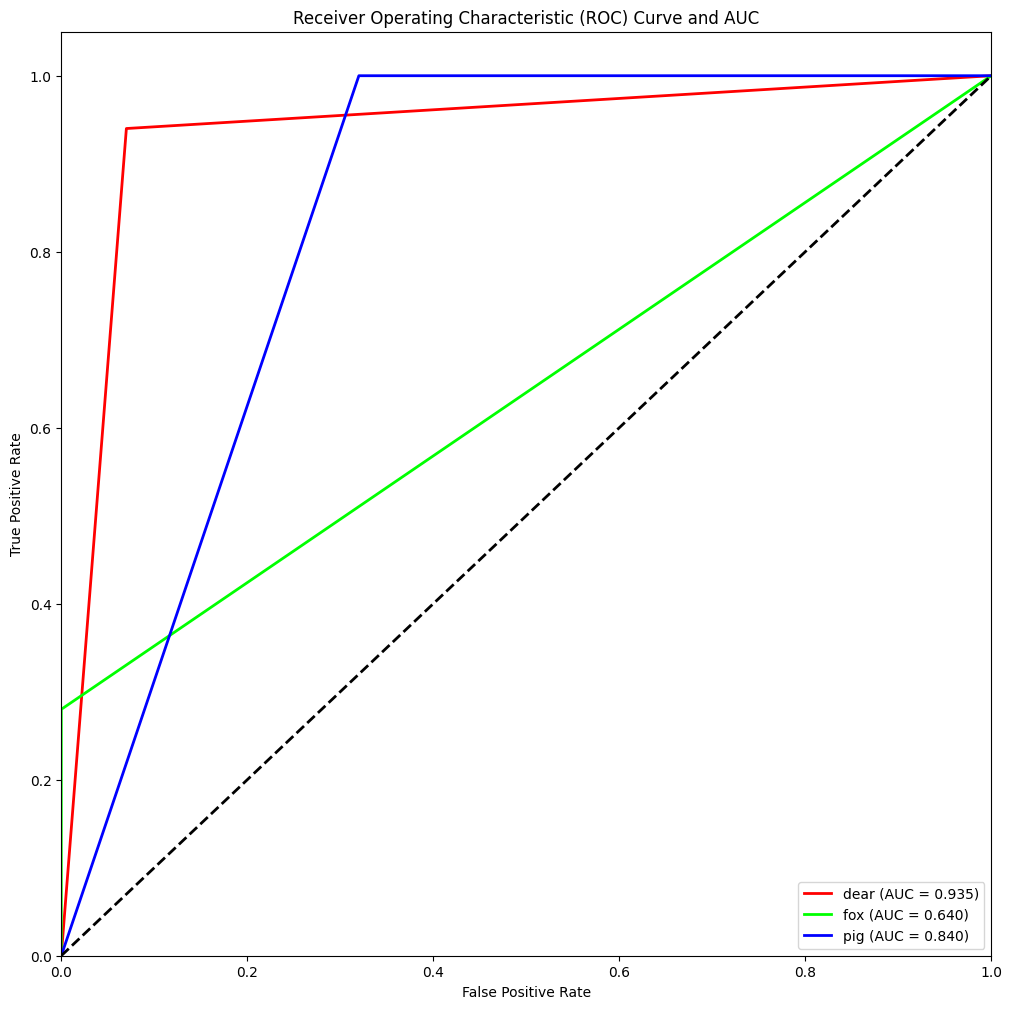

In [116]:
fpr, tpr, roc_auc = get_ROC_AUC(predicted_classes, true_labels)
save_ROC_AUC(fpr, tpr, roc_auc)

In [117]:
#save weights of the trained model to the specified folder
model.save_weights(os.path.join(model_save_dir, model_name + "_weights.h5"))

In [118]:
#save model to the specified folder
model.save(os.path.join(model_save_dir, model_name + ".h5"))

/mnt/c/Users/sumeela/FYP/Animal-Classification-at-Edge/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [119]:
#convert to tflite and save to new folder called tflite_models
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = os.path.join(os.getcwd(), 'tflite_models')
tflite_model_dir = os.path.join(tflite_models_dir, model_name)

if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

tflite_model_save_path = os.path.join(tflite_model_dir, model_name + ".tflite")
with open(tflite_model_save_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpt2aomr9o/assets


INFO:tensorflow:Assets written to: /tmp/tmpt2aomr9o/assets
2024-01-20 20:00:27.983271: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-20 20:00:27.983418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-20 20:00:28.098809: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt2aomr9o
2024-01-20 20:00:28.133404: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-20 20:00:28.133451: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpt2aomr9o
2024-01-20 20:00:28.254928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-20 20:00:28.301509: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-20 20:00:29.228431: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [130]:
#import tensor flow
import tensorflow as tf
import numpy as np
#open image and resizetest/fox/loc-h500ee07133326_007_196.jpg.jpg
img = tf.keras.preprocessing.image.load_img('test/dear/part0_sub004_2010_Unit162_Ivan093_img1554.jpg.jpg', target_size=(224, 224))

img = np.reshape(img, [1,224,224,3])
img = img/255

preds = model.predict(img)

#get the index of the highest probability class
preds = np.argmax(preds, axis=1)

print(preds)

print(class_names[preds[0]])

1/1 [==============================] - 2s 2s/step
[0]
Class 0


In [132]:

from sklearn.metrics import classification_report


#load tf lite model and want to calculate accuracy of the compressed model
interpreter = tf.lite.Interpreter(model_path=tflite_model_save_path)

true_labels = true_labels
predicted_labels = []

for images, labels in test_dataset:
    for image in images:
        image = tf.expand_dims(image, axis=0)
        interpreter.allocate_tensors()
        interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image)
        interpreter.invoke()
        preds = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
        preds = np.argmax(preds, axis=1)
        predicted_labels.extend(preds)

print(classification_report(true_labels, predicted_labels, target_names=class_names))




              precision    recall  f1-score   support

     Class 0       0.87      0.94      0.90       100
     Class 1       1.00      0.28      0.44       100
     Class 2       0.61      1.00      0.76       100

    accuracy                           0.74       300
   macro avg       0.83      0.74      0.70       300
weighted avg       0.83      0.74      0.70       300

